<a href="https://colab.research.google.com/github/annapahl24/exercise8/blob/main/Copy_of_CompModNervSys_exercise8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIOL 74.03 (SP23): Computational Modeling of the Nervous System
# Exercise 8: Simulating action potential propagation in myelinated and unmyelinated axons

### Exercise goals

1) Understand how voltages decay with distance according to the length constant

2) Simulate AP propagation and calculate conduction velocity

3) Explain why AP propagation is increased with diameter and with myelination


Work through the code below, running each cell, adding code where required, and making sure you understand the output. When you see questions with <font color='red'><b><i>Q:</i></b></font> preceding them, write your responses in text cells.


We'll first install neuron like last time

In [1]:
%pip install neuron # only need to run this cell once to install
                    # neuron in the local jupyter environment

Import the packages we'll be using

In [2]:
from neuron import h # all NEURON hoc functions are accessed through h
from neuron import gui # if you're running this notebook in a local environment (instead of on google colab), launches the GUI
h.load_file('stdrun.hoc') # loads neuron standard hoc library, not always necessary
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if 'google.colab' in str(get_ipython()): # For making interactive plots work on google colab
    from google.colab import output
    output.enable_custom_widget_manager()
else:
    plotly.offline.init_notebook_mode() # for printing notebooks offline

# Voltage decay in a passive axon

Let's start by making an axon model, similar to the previous exercise, but this time using more than 1 segment (`nseg` > 1). Now, the axon is no longer *isopotential* or *space-clamped* (as in the HH experiments), meaning the voltage can vary along the length.

This raises the question of how to set `nseg`, or in other words, how many numerical segments should be used? Similar to the time step for discretizing time, reducing the segment size (by increasing the number of segments) increases accuracy but with higher computational cost (simulations will take longer to run). One rule of thumb is called the *d_lambda rule*, which uses a term called the frequency dependent space constant $\lambda_{f}$. This is similar to the one we derived in class, but it incorporates the effect of the frequency of signals on their spatial attenuation. The d_lambda rule gives the biggest segment size $\Delta x$ to use for the frequency dependent length constant at a frequency of interest, given by:

$\Delta x \leq 0.1*\lambda_{f} = 0.1*\sqrt \frac{d}{4 \pi f \rho_{i}c_{m}}$.

Here, $d$ is diameter, $f$ is frequency, $\rho_{i}$ is specific resistance of the intracellular space, and $c_{m}$ is the specific membrane capacitance. Since the segment size is given by the section length $L$ divided by the number of segments `nseg` ($\Delta x = L/nseg$), you can use this equation to set `nseg` by rearranging to $nseg >= L/\Delta x$.

Our first model will be *passive* and linear, meaning there are no voltage-gated conductances (which produce *active*, nonlinear currents). The axon will have a diameter of $5 \; \mu m$ and length of $3 \; mm$.

For its biophysical properties, we'll then insert the `pas` mechanism, which includes `g_pas` and `e_pas`. The specific membrane capacitance `cm` is $1 \; \mu F / cm^{2}$ `g_pas` is $5 \cdot 10^{-4} S/cm^{2}$, and `e_pas` is 0 $mV$ (so we can visualize changes in $V_{m}$ from rest more easily). Finally, we'll also have to set a parameter we didn't use before, the axial resistance. In NEURON, this is given by the parameter `Ra`, which is equivalent to the *resistivity* $\rho$ used above and in class, with units $\Omega \cdot cm$. We'll set `Ra` to 200 $\Omega \cdot cm$.

Before we create our neuron model, write a function below to compute the maximum segment length using the d_lambda rule given above. Calculate the maximum segment length for the axon parameters given above and a frequency of 100 $Hz$ (reasonable for most neural signals we'd simulate).

In [3]:
def d_lambda(f, d, Ra, cm):
    # f - frequency in Hz
    # d - diameter in um (multiply by 1e-4 to convert to cm)
    # Ra - axial resistance in Ohm*cm
    # cm - membrane capacitance in uF/cm2 (multiply by 1e-6 to convert to F/cm2)
    d = d*1E-4 # convert to cm
    cm = cm*1E-6 # convert to F/cm2
    lambda_f = np.sqrt(d / (4 * np.pi * f * Ra * cm))
    deltax = 0.1 * lambda_f * 1e4  # deltax in um
    return deltax  # return the maximum segment length

# Calculate the maximum segment length for the axon parameters given
f = 100  # frequency in Hz
d = 5  # diameter in um
Ra = 200  # axial resistance in Ohm*cm
cm = 1  # membrane capacitance in uF/cm2
L = 3E3 # length in um

max_segment_length = d_lambda(f, d, Ra, cm)
nseg = L/max_segment_length;
print("nseg: ", nseg)



nseg:  67.25989459677514


You should get a number close to 67 segments (if you get stuck here, move on to the later steps with the `nseg` given below). This gives us a lower limit for the number of segments to use and obtain reasonably accurate results. To give ourselves a higher spatial resolution for visualizing the voltage profile along the axon, let's use 2 times this value, so 135 (round up to an odd number).

Now, use the parameters defined above to create your axon model by filling in the code below. You'll notice we use a `for` loop to set the biophysical parameters in each segment since we now have more than one segment in our axon *section*. As you may have gathered, this means these values can in general vary along an axon, allowing for complex models capturing variations in electrical properties within a neuron's morphology.

In [4]:
axon = h.Section(name='axon')

# Model geometry
axon.diam = 5  # um
axon.L = 3E3   # um
axon.nseg = 135

# Model biophysics
axon.insert('pas')  # Add passive mechanism
axon.Ra = 200       # Ohm cm

for seg in axon:
    seg.cm = 1             # uF/cm2
    seg.pas.g = 5e-4      # S/cm2
    seg.pas.e = 0         # mV

Now we have our axon model, what do we want to do with it? First, let's simulate the case of an intracellular current injection at the middle of our axon. This should give us some intuition for how signals decay within linear cables, which are relevant to both axons and dendrites. For the latter case, you can imagine a synaptic input generating a postsynpatic current somewhere along a dendrite, which would create some voltage profile along the cell and leading back to the soma. We'll simulate this explicitly in exercise 9, but hopefully that gives you an idea of why this is an important place to start.

**Create a current clamp that's inserted at the middle segment.**

**Set it's duration to $15 \; ms$, delay to $2 \; ms$, and amplitude to $1 \; nA$.**

For recording, we'll want to record the voltage over time at each of our compartments. The list comprehension in the code cell below shows how to generate an python list of NEURON vectors to record the voltage over time at each compartment. I also define a helper function `get_closest_index` that returns the index of a vector closest to a value you input. This can be used to get the segment position closest to any position you input (between 0 and 1), or the index of the time point closest to any time point you input.

In [5]:
# Create current clamp
iclamp = h.IClamp(0.5, sec=axon)  # Insert current clamp in the middle segment
iclamp.delay = 2  # ms
iclamp.dur = 15   # ms
iclamp.amp = 1    # nA

# Create recordings
t_vec = h.Vector()  # Time vector
t_vec.record(h._ref_t)
V_vecs = [h.Vector().record(seg._ref_v) for seg in axon]  # Record voltage at each segment of section
x_vals = np.array([seg.x for seg in axon])  # Normalized position (x) along axon for each segment, ranges from 0 to 1

# Define helper function to get index of recording for any position along axon
def get_closest_index(vec, val):
    # Finds closest value to x in x_vals vector, outputs index
    # If x > 1, outputs index for x = 1, and if x < 0, outputs index for x = 0
    return np.argmin(np.abs(vec - val))

Now to run a similation, we just need to specify the simulation settings. These are the initial voltage `h.v_init`, time step `h.dt`, duration `h.tstop`, and temperature `h.celsius`.

**Set the initial voltage to $0 \; mV$, time step to $0.01 \; ms$, duration to $30 \; ms$, and temperature to $20^{\circ} C$.**

There are no ion channels in this model, so the temperature won't affect anything, but we'll set it now for future use.

**Once these are set, run the simulation and plot the voltage over time at `x = 0.5`, `x = 0.25`, and `x = 0.75`.**

In [6]:
h.v_init = 0 # mV
h.steps_per_ms = 1/.01 # ensures dt can be set to desired value
h.dt = 0.01
h.tstop = 30 # ms
h.celsius = 20

h.run()

# Plot
plot_x_vals = [0.4,0.5,0.6]

fig = make_subplots()
for x in plot_x_vals:
    fig.add_trace(go.Scatter(x=t_vec,y=V_vecs[get_closest_index(x_vals,x)],name='Vm(x={})'.format(x)))
fig['layout']['xaxis']['title']='time (ms)'
fig.update_yaxes(title_text="Vm (mV)")


You should see an exponential charge up and decay in all compartments, similar to what we've seen for the single compartment RC model. But, now the steady state voltage achieved at the electrode location (`x = 0.5`) is clearly higher than locations on either side.

**Let's visualize how this spatial distribution evolves over time by plotting the voltage vs. position (`x`) at time $t$ = $3 \; ms$, $5 \; ms$, and $15 \; ms$ (remember the pulse starts at $2 \; ms$).**

**In a second plot, plot the normalized voltage vs. position (`x`) by dividing the voltage by its max value.**

In [7]:
plot_t_vals = [3, 5, 15]
V_vecs_arr = [np.array(v) for v in V_vecs]
V_vecs_arr = np.array(V_vecs_arr).T  # Convert to number of time points x number of segments matrix

# Plot V vs. x
fig = make_subplots()
for t in plot_t_vals:
    Vt = V_vecs_arr[get_closest_index(np.array(t_vec), t), :]
    fig.add_trace(go.Scatter(x=x_vals * axon.L, y=Vt, name='Vm(t={})'.format(t)))

fig['layout']['xaxis']['title'] = 'position (um)'
fig.update_yaxes(title_text="Vm (mV)")
fig.show()

# Plot V norm vs. x
fig_norm = make_subplots()
for t in plot_t_vals:
    Vt = V_vecs_arr[get_closest_index(np.array(t_vec), t), :]
    Vt_norm = Vt / max(Vt)
    fig_norm.add_trace(go.Scatter(x=x_vals * axon.L, y=Vt_norm, name='Vm(t={})'.format(t)))

fig_norm['layout']['xaxis']['title'] = 'position (um)'
fig_norm.update_yaxes(title_text="Normalized Vm")
fig_norm.show()

<font color='red'>***Q1:***  How does the spatial profile of voltage differ over time?
</font>

The maximum voltage (at the center) increases over the time of the pulse. The decay to either side also increases in magnitude however is still characterized by a steep drop off and then a leveling off at some steady state value close to zero (slightly higher than zero for t = 15 ms).

<font color='red'>***Q2:*** Is the spatial decay of $V$ at t = 3 or 5 ms described well by the length constant we derived in class ($\lambda = \sqrt{r_{m}/r_{i}}$)?
</font>

The spatial decay of V at t = 3 or 5 ms is not described well by the length constant we derived in class (𝜆=𝑟𝑚/𝑟𝑖‾‾√). The length constant provides an estimate of the distance over which the voltage decays to 36.7% of its initial value. However, in our case, the voltage distribution along the axon does not follow a simple exponential decay.

<font color='red'>***Bonus Q:*** Calculate the length constant for this axon. How does this compare to the distance from the current source at which the voltage is 36.7% of it's max value for t = 15 ms (our empirical definition of the length constant)?
</font>

In [18]:
# Calculate the length constant
V_max = max(V_vecs_arr[get_closest_index(np.array(t_vec), 15), :])
V_min = V_max * 0.367  # 36.7% of V_max
L = axon.L
lambda_empirical = L / np.log(V_max / V_min)

# Find the index of voltage closest to 36.7% of max at t = 15 ms
t_15_idx = get_closest_index(np.array(t_vec), 15)
Vt_15 = V_vecs_arr[t_15_idx, :]
V_36p7_idx = np.argmin(np.abs(Vt_15 - V_min))

# Compare to distance from the current source
x_36p7_empirical = x_vals[V_36p7_idx] * L

lambda_empirical, x_36p7_empirical

(2992.8368517179374, 1344.4444444444443)

Now that we've seen how voltage evolves over time and decays in space, let's gain a deeper understanding of how the neuron's parameters determine the spatiotemporal voltage profile for a current input. We'll focus on the axon's diameter (`diam`), membrane resistance (`1/g_pas`), and axial resistivity (`Ra`) and see how varying these parameters by a factor of 0.2 or 5 affects the steady state voltage distribution. Finish the code block below, taking some time to understand what each section is doing, and answer the questions below.

In [8]:
# finish code below
t_ss = 15  # ms - steady state time to extract
scaling_factors = [0.2, 1, 5]  # list of scaling factors

# Effect of diameter
diam0 = 5  # um - initial diameter (um)
Vss_diams = []
for f in scaling_factors:
    axon.diam = diam0 * f
    h.run()
    V_vecs_arr = np.array([np.array(v) for v in V_vecs]).T  # convert to number of time points x number of segments matrix
    Vss_diams.append(V_vecs_arr[get_closest_index(np.array(t_vec), t_ss), :])

axon.diam = diam0

# Effect of Rm
Rm0 = 1 / 5e-4  # initial membrane resistance (Ohm*cm^2)
Vss_Rms = []
for f in scaling_factors:
    axon.g_pas = 1 / (Rm0 * f)
    h.run()
    V_vecs_arr = np.array([np.array(v) for v in V_vecs]).T  # convert to number of time points x number of segments matrix
    Vss_Rms.append(V_vecs_arr[get_closest_index(np.array(t_vec), t_ss), :])

axon.g_pas = 1 / Rm0

# Effect of Ra
Ra0 = 200  # initial axial resistivity (Ohm*cm)
Vss_Ras = []
for f in scaling_factors:
    axon.Ra = Ra0 * f
    h.run()
    V_vecs_arr = np.array([np.array(v) for v in V_vecs]).T  # convert to number of time points x number of segments matrix
    Vss_Ras.append(V_vecs_arr[get_closest_index(np.array(t_vec), t_ss), :])

axon.Ra = Ra0

# Plot
var_names = ['Diameter', 'Rm', 'Ra']
Vss_all = [Vss_diams, Vss_Rms, Vss_Ras]
for Vss, name in zip(Vss_all, var_names):
    fig = make_subplots(rows=1, cols=1)
    for Vssi, f in zip(Vss, scaling_factors):
        fig.add_trace(go.Scatter(x=x_vals * axon.L, y=Vssi, showlegend=True, name='x{}'.format(f)))
    fig.update_layout(title=name)
    fig['layout']['yaxis']['title'] = 'V (mV)'
    fig['layout']['xaxis']['title'] = 'x (um)'
    # fig.update_layout(height=1000)
    fig.show()

<font color='red'>***Q3:*** How do the diameter, membrane resistance, and axial resistance affect the peak steady state voltage? Explain the reason for these trends by referencing the input resistance, discussed in class.
</font>

Diameter:
Peak steady-state voltage decreases with diameter. This is because increasing the diameter increases the input resistance.

Membrane resistance (1/g_pas):
Peak steady-state voltage increases with increasing membrane resistance.

Axial resistance (Ra):
Peak steady-state voltage increases with increasing axial resistance.

<font color='red'>***Q4:*** How do the diameter, membrane resistance, and axial resistance affect the relative decay of the voltage with length (in other words, the length constant)? It may help to plot `Vssi/Vssi.max()` so all the curves are normalized to their maxes.
</font>

Diameter: Decreasing diameter = faster relative decay
Rm: Changing Rm = same relative decay but steady state values increase with increasing Rm
Ra: Increasing Ra = faster relative decay, steady state values get even closer to zero too

<font color='red'>***Bonus Question:*** You may have notice we repeated the same for loop three times, while only changing which parameter of our model we changed, i.e., property of `axon`. Write a function in the code block below that replicates the loop above for any parameter of a neuron section, i.e., it should loop over a list of scaling factors, assign a new value, run a simulation, append the matrix of voltage recordings (V_vecs_arr) to a list, and then return the list. Make sure to reset the parameter to it's original value. Hint: You can use the `getattr` and `setattr` python functions
</font>

## AP propagation in unmyelinated and myelinated axons

Let's now turn to an active axon model, again using the Hodgkin-Huxley model for ionic currents.

We'll start with an unmyelinated axon model.

**Below, create a new axon with a diameter of $10 \; \mu m$ and length of $5 \; mm$. Again, set `nseg` to 135.**

**For its biophysical properties, insert the `hh` mechanism. Set `cm` to $1 \; \mu F / cm^{2}$, and leave the sodium, potassium, and leak conductances at their defaults. Finally, set `Ra` to $100 \; \Omega cm$.**

**For stimulation, insert an `IClamp` at the proximal side (`x = 0`) of the axon and apply a current pulse with $0.1 \; ms$ duration and $35 \; nA$ amplitude that starts at $2 \; ms$.**

Then, record the voltages at `x = 0.1` and `x  = 0.9` (this is given).

For simulation settings, set the initial voltage to $-65 \; mV$, time step to $0.01 \; ms$, duration to $10 \; ms$, and temperature to $20^{\circ} C$.

In [9]:
uaxon = h.Section(name='uaxon')
# Model geometry
uaxon.diam = 10  # um
uaxon.L = 5000  # um
uaxon.nseg = 135

# Model biophysics
uaxon.insert('hh')
for seg in uaxon:
    seg.cm = 1  # uF/cm2
uaxon.Ra = 100  # Ohm cm

# Stimulation
iclamp = h.IClamp(uaxon(0))
iclamp.delay = 2  # ms
iclamp.dur = 0.1  # ms
iclamp.amp = 35  # nA

# Recording
Vprox = h.Vector().record(uaxon(0.1)._ref_v)  # proximal
Vdist = h.Vector().record(uaxon(0.9)._ref_v)  # distal

# Simulation settings
h.v_init = -65  # mV
h.tstop = 10  # ms
h.celsius = 20  # °C
h.steps_per_ms = 1 / 0.01
h.dt = 0.01

Below, run a simulation and plot the voltage vs. time at your two locations overlaid on the same axis.

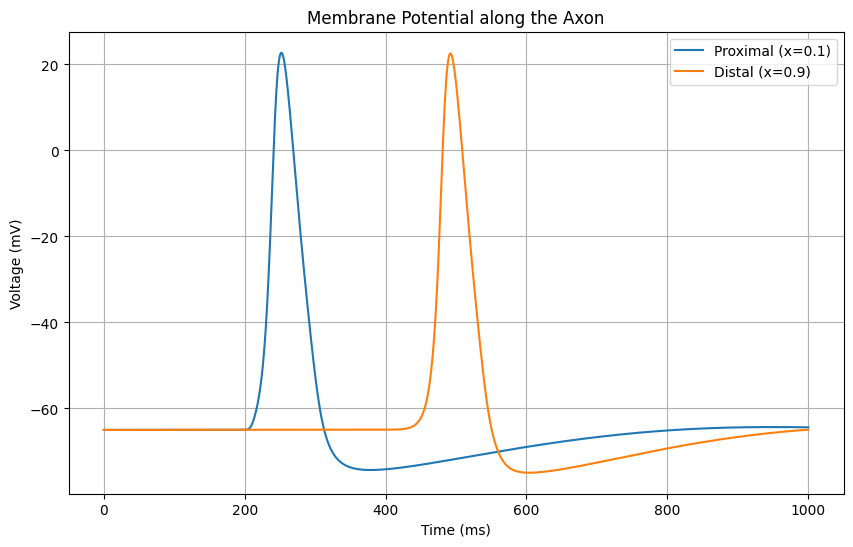

In [10]:
h.run()

# Plot here
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(Vprox, label='Proximal (x=0.1)')
plt.plot(Vdist, label='Distal (x=0.9)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Membrane Potential along the Axon')
plt.legend()
plt.grid(True)
plt.show()

You should see the action potential arrive at the more proximal (closer to the stimulus) location earlier than the distal one. We can calculate a conduction velocity by choosing a reference point within the AP waveform and comparing the time at which this point occurred at these two locations. An easy reference point to use is the AP peak, which we can get using `np.argmax`. Since there's only one AP in our simulation, we can assume the max value across the vector is the AP peak we're interested in.

Below, finish the function calculating conduction velocity (CV) using the voltage recording vectors and their relative locations. Remember, velocity is just distance travelled divided by time elapsed. Then, use it to calculate the CV for the simulation we just ran and print.

In [11]:
def calcCV1(V1, V2, x1, x2, L, t_vec):
    AP_peak1_ind = np.argmax(V1)
    AP_peak2_ind = np.argmax(V2)
    deltax = L * abs(x2 - x1) * 1e-3  # distance (converted to mm)
    deltat = abs(t_vec[AP_peak1_ind] - t_vec[AP_peak2_ind])  # difference in timing in ms
    CV = deltax / deltat
    return CV

# Calculate and print conduction velocity
CV = calcCV1(Vprox, Vdist, 0.1, 0.9, 5000, t_vec)
print("Conduction Velocity:", CV, "mm/ms")


Conduction Velocity: 1.6666666666667023 mm/ms


You should get a conduction velocity of around 1.65 m/s.

Now, let's explore how the axon diameter affects the speed of AP propagation, and therefore, information transmission. We know axons in both the central and peripheral nervous system have a wide range of diameters, from just under $1\; \mu m$ up to as large as $20 \mu m$ in humans, and as you know, up to $500 \; \mu m$ in the squid.

Below, adjust the diameter from $2 \; \mu m$ to $20 \; \mu m$, measure the CV using your `calcCV1` function, and plot CV vs. diameter.

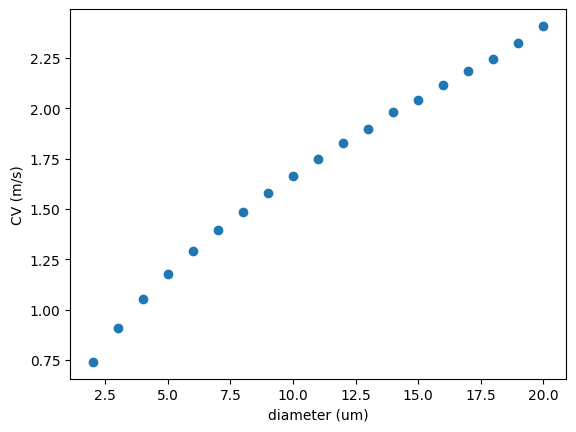

In [12]:
diams = np.arange(2, 21, 1)
CVs = []
h.celsius = 20

for d in diams:
    uaxon.diam = d
    h.run()
    CV = calcCV1(Vprox, Vdist, 0.1, 0.9, 5000, t_vec)
    CVs.append(CV)

uaxon.diam = 10  # reset to original

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(diams, CVs, 'o')
ax.set_xlabel('diameter (um)')
ax.set_ylabel('CV (m/s)')
plt.show()


<font color='red'>***Q5:*** Describe the trend you observe. Is this what you expect and why?


</font>

This increase in conduction velocity with increasing diameter is expected. Conduction velocity is directly proportional to the diameter of the axon according to the square root of the diameter, so it increases with the diameter. This is because a larger diameter results in less resistance to the flow of ions across the membrane, allowing for faster signal propagation.

I referred to the axon we're modeling as unmyelinated, so let's take a second to review what I mean by that. A large number of axons in both the central and peripheral nervous systems have repeating sections of their membrane wrapped with an insulating layer of lipid membrane called *myelin*. Myelin is formed by a *glia cells*, which are a separate class of cells in the nervous system that play a variety of roles, including myelinating axons both during development and in maturity.

<img src="https://pressbooks.umn.edu/app/uploads/sites/41/2020/05/myelin_sheath-1-1024x495.png" alt="Myelinated axon cross section - UMinn" width="512" height="249">

In between the myelinated sections, called *internodes*, are short (~$1 \; \mu m$), exposed regions of cell membrane called *nodes of Ranvier*. Since the myelin wrappings are predominantly lipid bilayers (no channels), they have very high membrane resistance. And since current passing through them would pass through the layers in series, their capacitance divides by the number of layers (while resistance adds in series), giving a much lower membrane capacitance. These two properties cause membrane currents to become restricted to the nodes of Ranvier and membrane voltage in the myelinated region to evolve more rapidly, leading to *saltatory propagation* of action potentials in myelinated axons, as in, the action potential "jumps" from node to node. This results in much faster propagation speeds without having to adjust diameter. Myelin is especially useful because biological organisms would generally like to transmit signals quickly (e.g., if you're being chased by a predator you want to be able to perceive and respond to the threat as fast as possible). But, our bodies have finite space and metabolic resources. So, by using myelin, axons can transmit rapid action potentials in smaller diameter axons.   

Below, we'll simulate a myelinated axon by making a set of myelin and node sections and connecting them, a NEURON function we haven't used yet. Another useful piece of information is that the length of internodal sections $INL$ is roughly 100 times the axon diameter in peripheral nerves ($INL = 100 \cdot diam$). Start with a myelinated axon composed of 21 nodes and 20 internodes, with a nodal diameter of $5 \; \mu m$ and length of $3 \; \mu m$. Use an `nseg` of 1 in the nodes 11 in the internodes.

For biophysical properties, we'll insert `hh` in the nodes and `pas` in the internodes. In all sections, set `Ra` = $100 \; \Omega cm$. In the nodes, set `gnabar_hh` to $1.2  S/cm^{2}$, `gkbar_hh` to $ 0.09 S/cm^{2}$, `gl_hh` to $ 0.02 S/cm^{2}$, and $el_hh` to -65 $mV$.

In the internodes, set `e_pas` to -65, membrane capacitance to $0.01 \; \mu F/cm^{-2}$, and passive membrane conductance `g_pas` to $1\cdot 10^{-5} \; S/cm^{2}$.

For stimulation instrumentation, insert an `IClamp` at the proximal side (`x = 0.5` of `node[0]`) of the axon and apply a current pulse with $0.1 \; ms$ duration and $5 \; nA$ amplitude that starts at $2 \; ms$. Then, record the voltages at `x = 0.1` and `x  = 0.9`.

I'll wrap all this in a function to make it easier to reuse in other code.

In [13]:
diam0 = 5
N_nodes = 21
def make_myelinated_axon(N_nodes,diam):
    # Create sections and connect
    node = [h.Section(name=f'node[{i}]') for i in range(N_nodes)]
    internode = [h.Section(name=f'internode[{i}]') for i in range(N_nodes-1)]
    for i in np.arange(0,N_nodes-1):
        internode[i].connect(node[i](1),0) # connect start of internode to end of node i
        node[i+1].connect(internode[i](1),0)
    for n in node:
        # Geometry
        n.L = 3
        n.diam = diam
        n.nseg = 1
        # Biophysics
        n.cm = 1
        n.Ra = 100
        n.insert('hh')
        n.gnabar_hh = 1.2
        n.gkbar_hh = 0.09
        n.gl_hh = 0.02
        n.el_hh = -65
    for inode in internode:
        # Geometry
        inode.L = 100*diam
        inode.diam = diam
        inode.nseg = 11
        # Biophysics
        inode.Ra = 100
        inode.insert('pas')
        inode.e_pas = -65
        inode.g_pas = 1e-5
        inode.cm = 0.01
    # stimulation
    iclamp = h.IClamp(node[0](0.5))
    iclamp.delay = 2
    iclamp.amp = 5
    iclamp.dur = 0.1
    # Recording
    V_nodes = [h.Vector().record(sec(0.5)._ref_v) for sec in node]
    node_centers = []
    psec_x = 0
    for sec in node[0].subtree():
        x_sec = sec.L/2 + psec_x
        if 'internode' not in sec.name():
            node_centers.append(x_sec)
        psec_x = x_sec
    return node, internode, node_centers, iclamp, V_nodes

node, internode, node_centers,iclamp3,V_nodes = make_myelinated_axon(N_nodes,diam0)


Use `h.topology()` in the code cell below to check that our myelinated axon looks like it's supposed to. It may help to use fewer nodes to visualize the topology more easily.

In [14]:
h.topology()


|---------------------------------------------------------------------------------------------------------------------------------------|       axon(0-1)
|---------------------------------------------------------------------------------------------------------------------------------------|       uaxon(0-1)
|-|       node[0](0-1)
   `----------|       internode[0](0-1)
               `|       node[1](0-1)
                 `----------|       internode[1](0-1)
                             `|       node[2](0-1)
                               `----------|       internode[2](0-1)
                                           `|       node[3](0-1)
                                             `----------|       internode[3](0-1)
                                                         `|       node[4](0-1)
                                                           `----------|       internode[4](0-1)
                                                                       `|       node[5](0-1)
  

1.0

For simulation settings, set the initial voltage to $-65 \; mV$, time step to $0.01 \; ms$, duration to $10 \; ms$, and temperature to $20^{\circ} C$. Plot the voltage vs. time at the 3rd and 19th nodes on the same axes.

Text(0, 0.5, 'Vm (mV)')

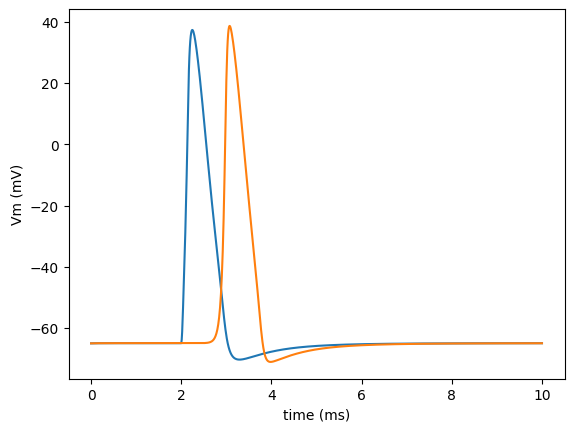

In [15]:
# Simulation settings
h.v_init = -65
h.steps_per_ms = 1/.01
h.dt = 0.01
h.tstop = 10
h.celsius = 20

# Run
h.run()

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(t_vec,V_nodes[2])
ax.plot(t_vec,V_nodes[18])
ax.set_xlabel('time (ms)')
ax.set_ylabel('Vm (mV)')


Now modify your old `calcCV1` function to create a new function called `calcCV2` to calculate the conduction velocity for the myelinated axon. Calculate the CV for this axon and print the output. Hint: the `node_centers` list created above gives you the location of each node in $\mu m$.

> Add blockquote



In [16]:
def calcCV2(V1, V2, x1, x2, t_vec, node_centers):
    AP_peak1_ind = np.argmax(V1)
    AP_peak2_ind = np.argmax(V2)
    deltax = abs(node_centers[x2] - node_centers[x1])*1E-3  # distance in um
    deltat = abs(t_vec[AP_peak1_ind] - t_vec[AP_peak2_ind])  # difference in timing in ms
    CV = deltax / deltat  # m/s
    return CV

CV_myelinated = calcCV2(V_nodes[2], V_nodes[18], 2, 18, t_vec, node_centers)
print("Conduction velocity for myelinated axon:", CV_myelinated, "m/s")


Conduction velocity for myelinated axon: 4.907317073170836 m/s


You should get a CV for this axon of about 4.9 m/s.

Finally, let's compare the dependence of CV on axon diameter in the myelinated axon to the unmyelinated case we simulated above.

Below, adjust the diameter again from $2 \; \mu m$ to $20 \; \mu m$, measure the CV using your `calcCV2` function, and plot CV vs. diameter on an axes including both the myelinated and unmyelinated axon data.

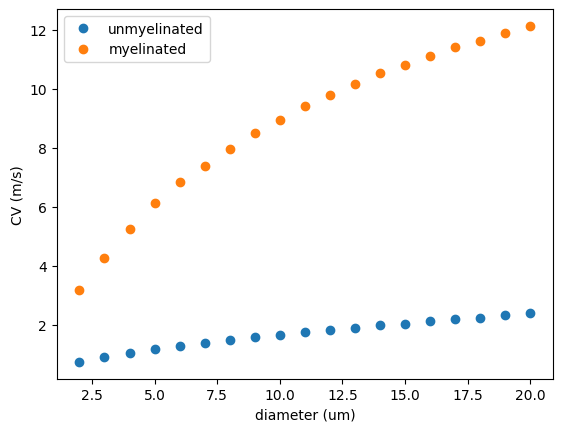

In [17]:
N_nodes = 21
diams = np.arange(2, 21, 1)
CVsM = []
h.celsius = 20

for d in diams:
    uaxon.diam = d
    node, internode, node_centers, iclamp3, V_nodes = make_myelinated_axon(N_nodes, d)
    h.run()
    CVsM.append(calcCV2(V_nodes[2], V_nodes[18], 0, 20, t_vec, node_centers))

uaxon.diam = 10  # reset to original

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(diams, CVs, 'o', label='unmyelinated')
ax.plot(diams, CVsM, 'o', label='myelinated')
ax.set_xlabel('diameter (um)')
ax.set_ylabel('CV (m/s)')
ax.legend()
plt.show()


<font color='red'>***Q6:*** What effect did the presence of myelin have on conduction velocities across diameters?
</font>

Myelination increases conduction velocities across all diameters much more than just the increase we see in CV with diameter increase in unmyelinated axons (0.5-2 m/s for unmyelinated vs. 3-12 for m/s myelinated).